In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib

# Update the path to your local directory containing the images
data_dir = pathlib.Path("D:/TY- SEM 6/Project/OvarianCystDetectionCNN/PCOS")

# If you want to get a list of all image files in the directory, you can use something like this
image_files = list(data_dir.glob('*/*.jpg'))  # Assuming your images are in JPEG format

# Example of how to print the first few image file paths
for img_path in image_files[:5]:
    print(img_path)


D:\TY- SEM 6\Project\OvarianCystDetectionCNN\PCOS\infected\img1.jpg
D:\TY- SEM 6\Project\OvarianCystDetectionCNN\PCOS\infected\img10.jpg
D:\TY- SEM 6\Project\OvarianCystDetectionCNN\PCOS\infected\img2.jpg
D:\TY- SEM 6\Project\OvarianCystDetectionCNN\PCOS\infected\img3.jpg
D:\TY- SEM 6\Project\OvarianCystDetectionCNN\PCOS\infected\img4.jpg


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1922


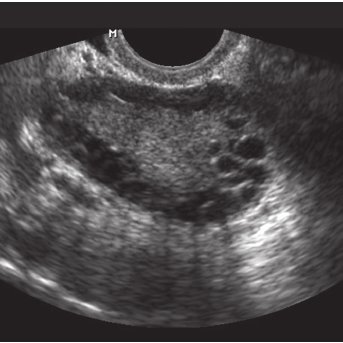

In [7]:
infected = list(data_dir.glob('infected/*'))
PIL.Image.open(str(infected[0]))

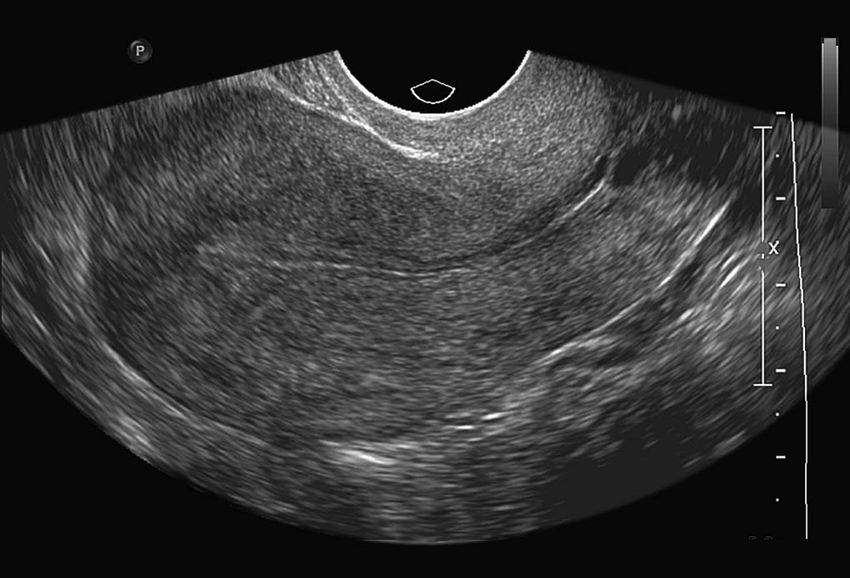

In [8]:
notinfected = list(data_dir.glob('notinfected/*'))
PIL.Image.open(str(notinfected[2]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1924 files belonging to 2 classes.
Using 1540 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1924 files belonging to 2 classes.
Using 384 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['infected', 'notinfected']


## Visualize the data
Here are the first nine images from the training dataset:

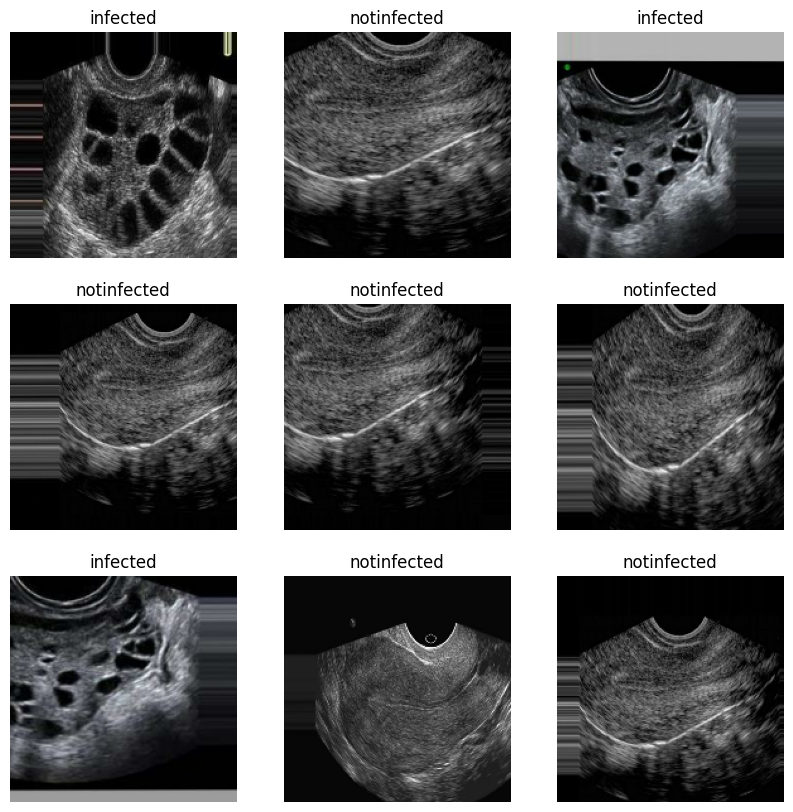

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


 The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99875855


In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8377 - loss: 0.3663 - val_accuracy: 0.9844 - val_loss: 0.0459
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9981 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 1.0000 - loss: 1.3862e-04 - val_accuracy: 1.0000 - val_loss: 5.8406e-04
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 1.0000 - loss: 6.1851e-05 - val_accuracy: 1.0000 - val_loss: 3.9032e-04
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 1.0000 - loss: 3.5272e-05 - val_accuracy: 1.0000 - val_loss: 3.9968e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 1.0000 - loss: 2.2267e-05 - val_accuracy: 1.0000 - val_loss: 6.4367e-04
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 1.0000 - loss: 

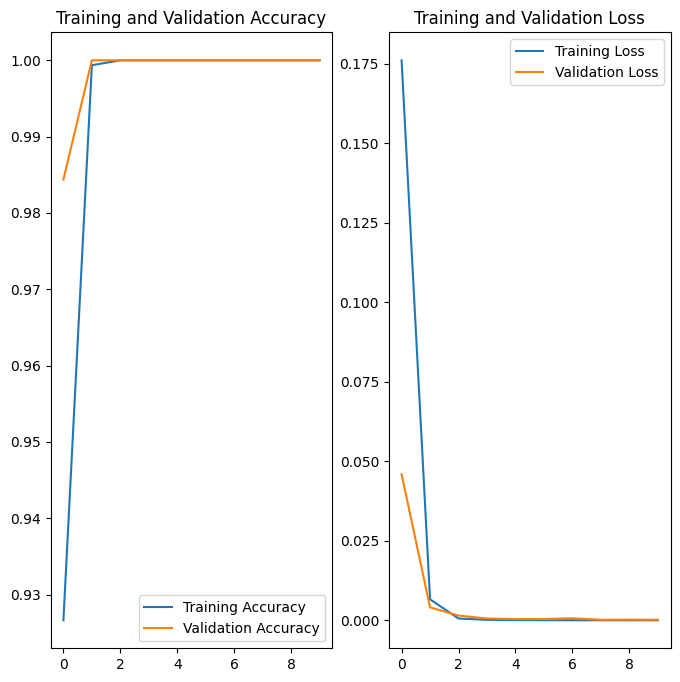

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

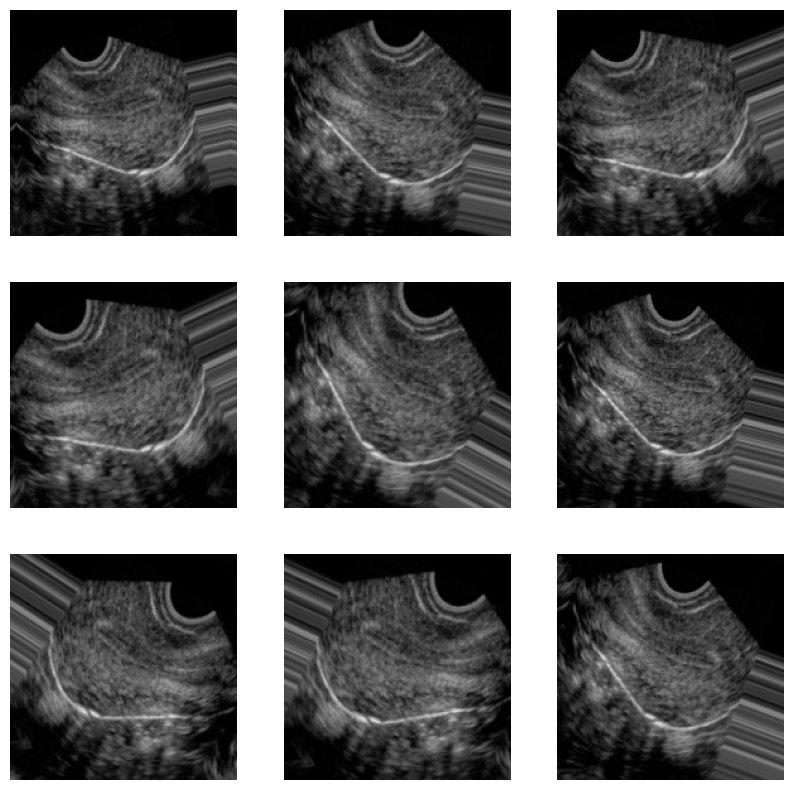

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.7328 - loss: 0.4690 - val_accuracy: 0.9974 - val_loss: 0.0085
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.9934 - loss: 0.0189 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step - accuracy: 0.9978 - loss: 0.0060 - val_accuracy: 0.9766 - val_loss: 0.0582
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 524ms/step - accuracy: 0.9894 - loss: 0.0260 - val_accuracy: 1.0000 - val_loss: 3.9392e-04
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 579ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 4.2018e-04
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 1.0000 - loss: 3.7628e-04 - val_accuracy: 1.0000 - val_loss: 5.5225e-05
Epoch 8/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 1.0000 - loss: 1.518

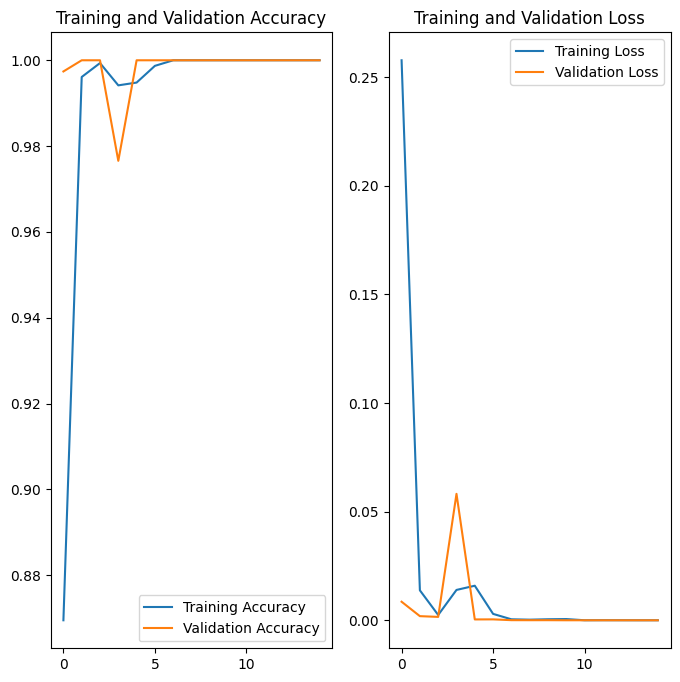

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
import tensorflow as tf
import numpy as np

# Define img_height and img_width
img_height = 180
img_width = 180

# Define the URL and path for the image
i4_url = "D:/TY- SEM 6/Project/OvarianCystDetectionCNN/i4.jpg"
i4_path = i4_url  # No need to use tf.keras.utils.get_file if the image is already local

# Load the image
img = tf.keras.utils.load_img(i4_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Load or define your model
# model = ...  # Load or define your model here

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get class names
class_names = []  # Define your class names here

# Print the prediction result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


IndexError: list index out of range